# Обработка и разбор данных от Semantic Hub

In [92]:
import pandas as pd
import os
from tqdm import tqdm
import re
import json
from collections import Counter
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sns.__version__

'0.11.1'

## Заходим в папку с полученными данными и получаем список файлов

In [4]:
# путь к папке со всеми файлами
path = '/Users/egor/Desktop/SemanticHub/diploma/relatives_data/jsons'

In [5]:
list_of_files = os.listdir(path) # список названий файлов

## Делаем список json объектов, с которыми удобно работать

In [6]:
list_full_file_json = [] # список, в котором каждый элемент - содержимое одного файла

# цикл для прохода по всем файлам и сбора их содержимого
for filename in tqdm(list_of_files):
    # абсолютный путь к единичному файлу
    path_single = path + '/' + filename
    # открываем
    with open(path_single) as file:
        file = json.load(file)
        list_full_file_json.append(file)

100%|██████████| 386254/386254 [02:59<00:00, 2153.91it/s]


In [7]:
# пример удобной работы
list_full_file_json[90564]['text']

"xml version='1.0' encoding='UTF-8'? https://dia-club.ru/forum_ru/viewtopic.php?f=6&t=3311#0099 2020-12-03 Converted by Semantic Hub (c) 2021 1.0 https://dia-club.ru/forum_ru/viewtopic.php?f=6&t=3311 dia-club.ru ru Статистика по детскому разделу 99 2007 Сахарный диабет у детей Список форумов Сахарный диабет, основные разделы форума Сахарный диабет у детей Sphinx https://dia-club.ru/forum_ru/memberlist.php?mode=viewprofile&u=4108 Москва 50 26 ноя 2007, 13:27 2007 дочь Полина, родилась 22.09.2005 диагноз СД1 в ноябре 2007 "

## Подготовим поле *text* к обработке

In [8]:
# для этого удалим все, кроме текста самого сообщения
# вообще можно будет пытаться еще пол вытягивать и всякие другие данные типа даты, города, имени

# 1

# текст окружен двумя пробелами странной длины, это нам поможет
pattern = re.compile('                      (.*)                  ')

# это будет список номеров тех сообщений, которые не прошли по первому паттерну
i = 0
list_err = []

for message in tqdm(list_full_file_json):
    try:
        message['text'] = pattern.search(message['text']).group(1)
        i += 1
    except AttributeError:
        list_err.append(i)
        i += 1


100%|██████████| 386254/386254 [00:09<00:00, 38720.75it/s]


In [9]:
list_err[:10]

[288, 531, 639, 658, 710, 736, 774, 1030, 1034, 1155]

In [10]:
# 2

# ненужный текст начиается с хмл, а заканчивается годом, после нее идет само сообщение
# возможно такое, что в сообщении есть упоминание года, поэтому оно будет урезано, но иначе работать сложно, 
# потому что встречается много вариантов времени и других вещей перед годом:
# наличие/отсутсвие часа, секунд, UTC и т.п.
# 
# upd: посмотрел глазами, некрасивых вариантов особо не заметил
pattern = re.compile('xml.*\d\d\d\d(.*)')

for number in tqdm(list_err):
    if pattern.search(list_full_file_json[number]['text']).group(1) != ' ':
        list_full_file_json[number]['text'] = pattern.search(list_full_file_json[number]['text']).group(1)
    

100%|██████████| 3269/3269 [00:00<00:00, 41664.05it/s]


In [11]:
for number in list_err[50:200]:
    print(list_full_file_json[number]['text'])
    print('//////////////////////////////////////')

 мы с женой лечимся от гонореи . можно ли заниматься сексом в презервативе ? 
//////////////////////////////////////
 Отличый совет, моя мама меня так лечила, была аллергия на морковку, даю уже месяц! 
//////////////////////////////////////
 так профилактику сыну. бифиформ 2 раза в день. не должен заболеть. 
//////////////////////////////////////
 *плавание. А у оперированного брата штифтов нет! 
//////////////////////////////////////
 Смотря для чего эта операция применяется. Что Ваша сестра лечит? 
//////////////////////////////////////
 что такое депостат. маме его назначили, но зачем и при каких диагнозах их назначают. 
//////////////////////////////////////
 Антошика с 8 месячьем! :rose: маме не хандрить, не болеть :rose: 
//////////////////////////////////////
 Игорь, мужу лечиться по той же схеме, что и мне? 
//////////////////////////////////////
 от согаза в виталлЕ хожу, врач Бобыле С.В., сыну (4 года) там же лечим зубки. 
//////////////////////////////////////
 Хороший спосо

In [12]:
# уберем форумные смайлики из сообщений
pattern = re.compile(':[a-zA-Z]+:')

for message in tqdm(list_full_file_json):
        message['text'] = pattern.sub('', message['text'])


100%|██████████| 386254/386254 [00:03<00:00, 104640.40it/s]


In [13]:
list_json_save = list(list_full_file_json) # перед удалением пробелов

In [14]:
# заменим множественные пробелы на единичные,
# уберем пробелы в начале и в конце предложения

# паттерн для поиска пробелов
pattern = re.compile('\s+')

for message in tqdm(list_full_file_json):
    message['text'] = pattern.sub(' ', message['text'])
    # убираю пробел в начале
    if message['text'][0] == ' ':
        message['text'] = message['text'][1:]
    # убираю пробел в конце    
    if message['text'][-1:] == ' ':
        message['text'] = message['text'][:len(message['text'])-1]
    # добавляю знак препинания в конце, если его нет. 
    if message['text'][-1:] != '.' and message['text'][-1:] != '!' and  message['text'][-1:] != '?' and  message['text'][-1:] != '…':
        message['text'] = message['text'] + '.'
        
        
        

100%|██████████| 386254/386254 [00:26<00:00, 14848.83it/s]


In [15]:
list_full_file_json[90564]['text']

"xml version='1.0' encoding='UTF-8'? https://dia-club.ru/forum_ru/viewtopic.php?f=6&t=3311#0099 2020-12-03 Converted by Semantic Hub (c) 2021 1.0 https://dia-club.ru/forum_ru/viewtopic.php?f=6&t=3311 dia-club.ru ru Статистика по детскому разделу 99 2007 Сахарный диабет у детей Список форумов Сахарный диабет, основные разделы форума Сахарный диабет у детей Sphinx https://dia-club.ru/forum_ru/memberlist.php?mode=viewprofile&u=4108 Москва 50 26 ноя 2007, 13:27 2007 дочь Полина, родилась 22.09.2005 диагноз СД1 в ноябре 2007."

Поле **text** подготовлено, можно провести количественный анализ и построить разные визуализации

## Анализ текстового содержания – поле *text*

Для проведения анализа заполним датафрейм пандас важными для анализа характеристиками:
+ количество слов в каждом документе
+ количество предложений в каждом документе
+ количество цепочек кореференции в каждом документе
+ количество выделенных слов в каждом документе



+ количество цепочек кореференции всего
+ количество выделенных слов всего
+ количество документов всего

### Распределение количества слов в каждом документе

In [16]:
# список количеств слов
words_list = []
# паттерн для деления по пробелам/переносам
pattern = re.compile('\s+')

for message in tqdm(list_full_file_json):
    words_message = len(pattern.split(message['text']))
    words_list.append(words_message)

100%|██████████| 386254/386254 [00:22<00:00, 17029.57it/s]


In [17]:
# посмотрим на самые частые количества слов на одно сообщение
c = Counter(words_list).most_common(10)
c

[(61, 2731),
 (55, 2720),
 (56, 2688),
 (57, 2672),
 (40, 2671),
 (52, 2669),
 (64, 2659),
 (54, 2656),
 (53, 2655),
 (47, 2642)]

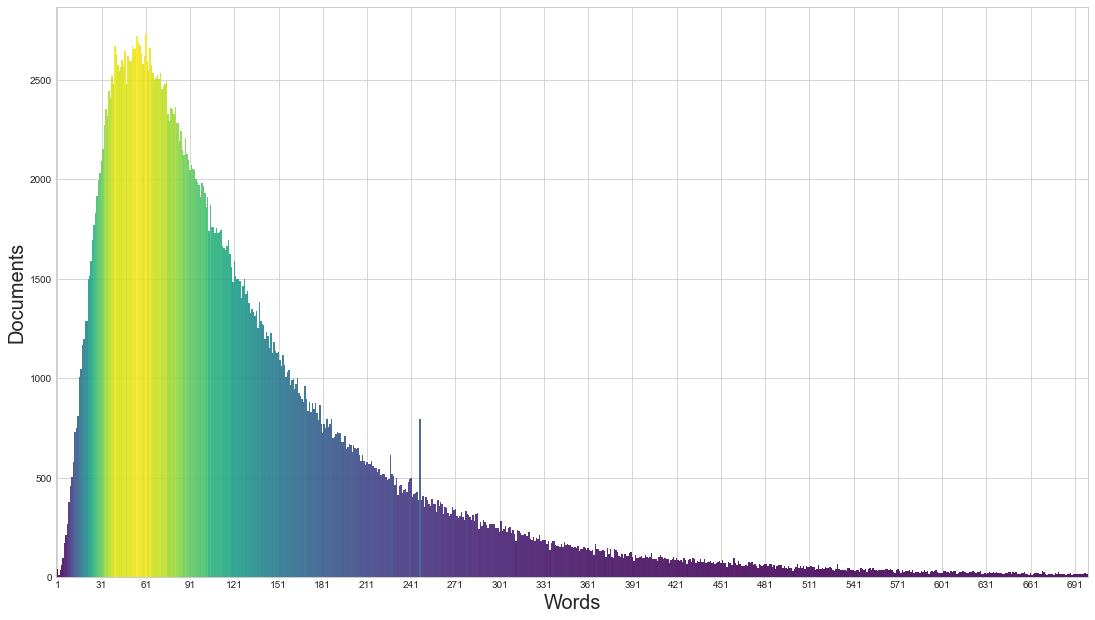

In [171]:
# построим по полученным данным нормализованную гистограмму
c = Counter(words_list)
keys = list(c.keys())
values = list(c.values())

#n, bins, patches = sns.histplot(x=keys, weights=values, discrete=True, , bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n, bins, patches = plt.hist(x = keys, weights=values, bins=np.arange(len(keys))-0.5, facecolor='#2ab0ff', alpha=0.9)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.style.use('seaborn-whitegrid')

plt.xticks(np.arange(min(keys), max(keys)+1, 30.0))
plt.xlim(0, 700)

plt.xlabel('Words', fontsize=20)
plt.ylabel('Documents', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

### Распределение количества предложений в каждом документе

In [19]:
# список количеств слов
sentences_list = []
# паттерн для деления на предложения, объяснение:(https://regex101.com/r/he9d1P/1)
# почти всегда делит правильно, в предлоежниях с именем и отчеством через точку ошибается на +1, что
# для выборки в 400к незначительно
pattern = re.compile('.*?(\.|\?|\!|…)(?= *[А-Я]|$)')

for message in tqdm(list_full_file_json):
    sentences_message = len(pattern.findall(message['text']))
    sentences_list.append(sentences_message)

100%|██████████| 386254/386254 [00:10<00:00, 35161.13it/s]


In [20]:
# посмотрим на самые частые количества предложений на одно сообщение
c = Counter(sentences_list).most_common(15)
c

[(1, 30858),
 (5, 27663),
 (6, 26935),
 (4, 26777),
 (7, 25319),
 (3, 24184),
 (8, 23094),
 (2, 20998),
 (9, 20631),
 (10, 18486),
 (11, 16236),
 (12, 14368),
 (13, 12303),
 (14, 10882),
 (15, 9619)]

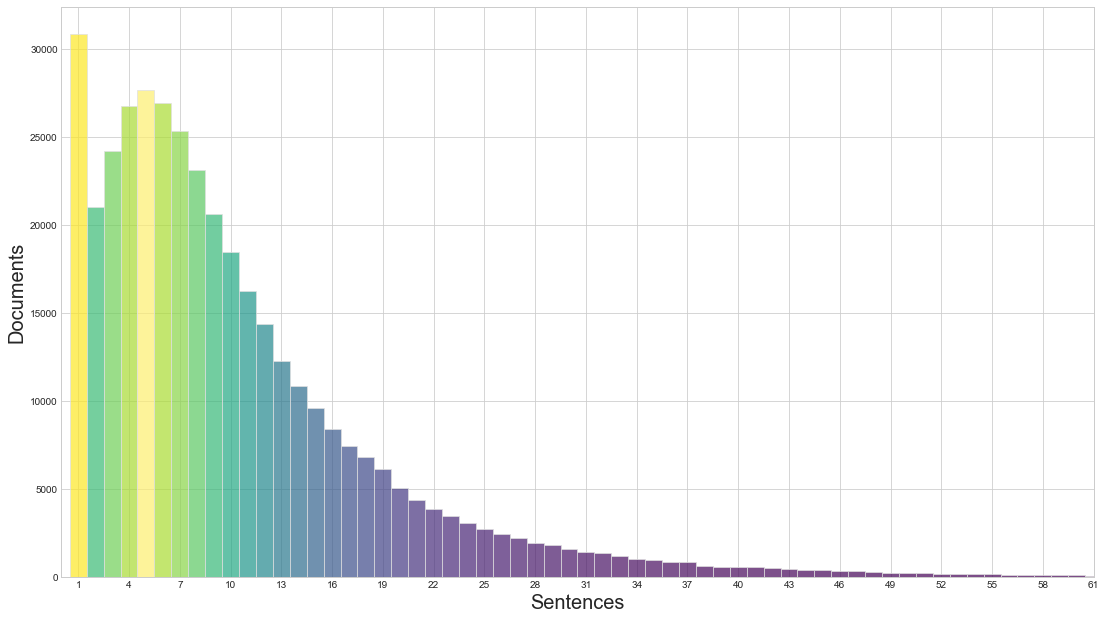

In [166]:
# построим по полученным данным нормализованную гистограмму
c = Counter(sentences_list)
keys = list(c.keys())
values = list(c.values())

#n, bins, patches = sns.histplot(x=keys, weights=values, discrete=True, , bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n, bins, patches = plt.hist(x = keys, weights=values, bins=np.arange(len(keys))-0.5, facecolor='#2ab0ff', edgecolor='#e0e0e0', alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.style.use('seaborn-whitegrid')

plt.xticks(np.arange(min(keys), max(keys)+1, 3.0))
plt.xlim(0, 61)

patches[5].set_fc('#FDEE70') # Set color

plt.xlabel('Sentences', fontsize=20)
plt.ylabel('Documents', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

### Количество кореференциальных цепочек в каждом документе

In [22]:
# скрипт для приведения каждого размеченного для кореференции элемента к JSON виду
# для удобного обращения к параметрам
files_chain_list = []

for message in tqdm(list_full_file_json):
    list_coref_ent = message['annotation_sets']['']['annotations']
    message_chain_list = []
    
    for entity in list_coref_ent:
        entity = str(entity)[13:-1]  # адхок подрезка формата SH
        entity = ast.literal_eval(entity) # превращаю строку в виде дикта в дикт
        entity = json.dumps(entity) # делаем джсон из дикта
        message_chain_list.append(json.loads(entity)) # парсим джсон в список
        
    files_chain_list.append(message_chain_list) # в этом списке каждый файл идет отдельным списком-джсоном
    
    


100%|██████████| 386254/386254 [03:45<00:00, 1716.51it/s]


In [23]:
# теперь составим список, где каждый элемент будет представлять количество цепочек в документе
chain_amount_list = []

for json in tqdm(files_chain_list):
    chain_num_list = []
    
    for word in json:
        chain_num_list.append(word['antecedent_id'])
        
    # через каунтер приведем все к списку туплов и посчитаем количество туплов
    c = Counter(chain_num_list)
    chain_amount_list.append(len(c))

100%|██████████| 386254/386254 [00:13<00:00, 28238.12it/s]


In [24]:
c = Counter(chain_amount_list).most_common(15)
c

[(3, 72852),
 (2, 71844),
 (4, 58352),
 (1, 42884),
 (5, 42401),
 (6, 29204),
 (7, 19644),
 (8, 13345),
 (9, 9034),
 (10, 6379),
 (11, 4588),
 (12, 3284),
 (13, 2425),
 (14, 1853),
 (0, 1437)]

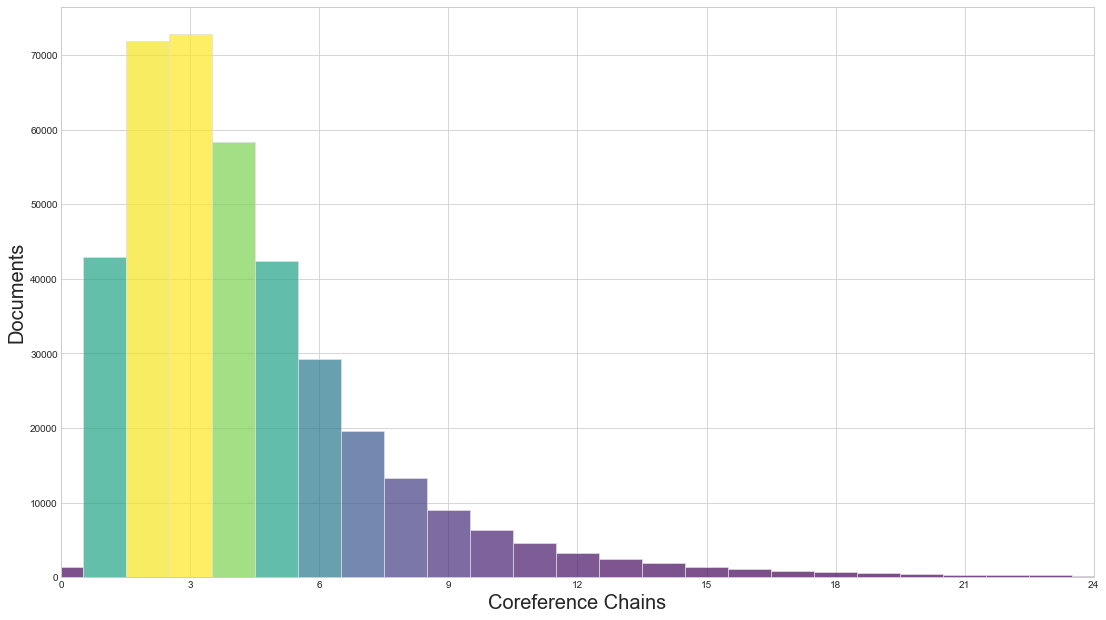

In [152]:
# построим по полученным данным нормализованную гистограмму
c = Counter(chain_amount_list)
keys = list(c.keys())
values = list(c.values())

#n, bins, patches = sns.histplot(x=keys, weights=values, discrete=True, , bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n, bins, patches = plt.hist(x = keys, weights=values, bins=np.arange(len(keys))-0.5, facecolor='#2ab0ff', edgecolor='#e0e0e0', alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.style.use('seaborn-whitegrid')

plt.xticks(np.arange(min(keys), max(keys)+1, 3.0))
plt.xlim(0, 24)

plt.xlabel('Coreference Chains', fontsize=20)
plt.ylabel('Documents', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

### Распределение количества слов, выделенных, как значимые для кореференции. 

In [25]:
# сделаем список, каждый элемент которого - количество выделенных сущностей на файл
chain_entity_count_list = []

for chain_list in tqdm(files_chain_list):
    file_chain = len(chain_list)
    chain_entity_count_list.append(file_chain)

100%|██████████| 386254/386254 [00:00<00:00, 391877.04it/s]


In [26]:
# посмотрим на самые частые количества выделенных слов на одно сообщение
c = Counter(chain_entity_count_list).most_common(10)
c

[(3, 46122),
 (2, 44140),
 (4, 42001),
 (5, 36185),
 (6, 30509),
 (1, 27508),
 (7, 25025),
 (8, 21018),
 (9, 16878),
 (10, 13912)]

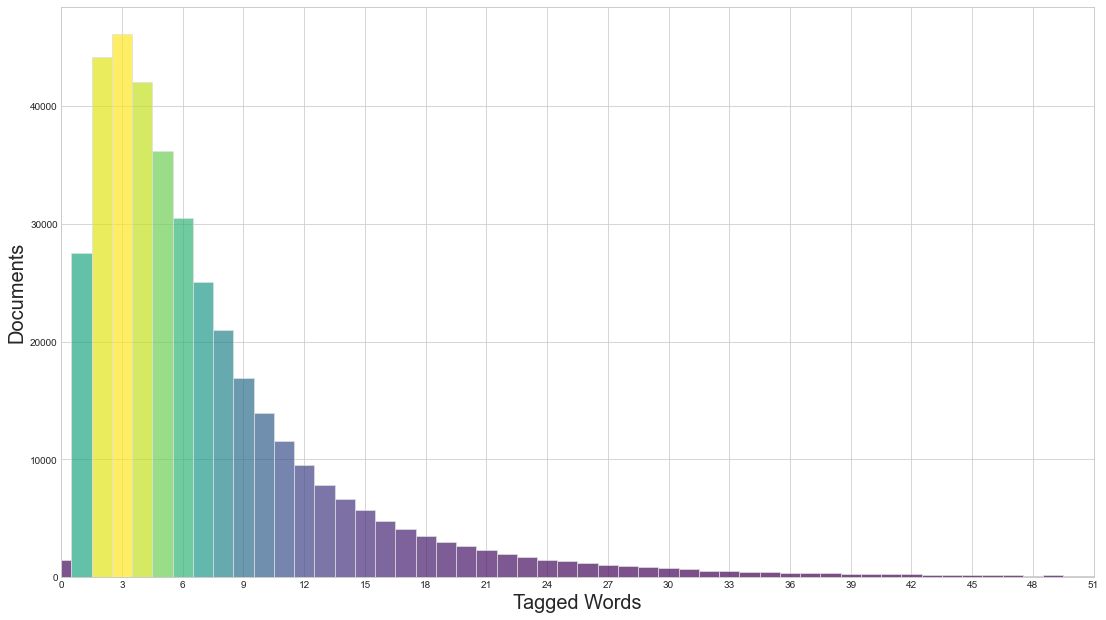

In [167]:
# построим по полученным данным нормализованную гистограмму
c = Counter(chain_entity_count_list)
keys = list(c.keys())
values = list(c.values())

#n, bins, patches = sns.histplot(x=keys, weights=values, discrete=True, , bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n, bins, patches = plt.hist(x = keys, weights=values, bins=np.arange(len(keys))-0.5, facecolor='#2ab0ff', edgecolor='#e0e0e0', alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.style.use('seaborn-whitegrid')

plt.xticks(np.arange(min(keys), max(keys)+1, 3.0))
plt.xlim(0, 51)

plt.xlabel('Tagged Words', fontsize=20)
plt.ylabel('Documents', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

### Общее количество кореференциальных цепочек

In [27]:
# список количества цепочек в сообщении
c = Counter(chain_amount_list).most_common()
# счетчик цепочек
counter = 0

for pair in tqdm(c):
    counter += pair[0]*pair[1]
counter

100%|██████████| 64/64 [00:00<00:00, 402451.96it/s]


1693773

### Общее количество элементов в кореференциальных цепочках 

In [28]:
# список количества выделенных слов в сообщении
c = Counter(chain_entity_count_list).most_common()
# счетчик цепочек
counter = 0

for pair in tqdm(c):
    counter += pair[0]*pair[1]
counter

100%|██████████| 136/136 [00:00<00:00, 567023.20it/s]


2968033

### Отношение количества слов в сообщении к количеству цепочек

In [64]:
# количество слов по сообщениям уже есть
# количество цепочек по сообщениям уже есть
# осталось посчитать количество каждых возможных пар
word_chain_count_list = []
for word_count, chain_count in zip(words_list, chain_amount_list):
    word_chain_count_list.append((word_count, chain_count, ))
c = Counter(word_chain_count_list)
c

Counter({(16, 2): 404,
         (173, 2): 93,
         (177, 4): 149,
         (50, 2): 726,
         (127, 6): 134,
         (62, 4): 460,
         (92, 3): 457,
         (58, 2): 659,
         (249, 7): 40,
         (51, 3): 625,
         (83, 3): 531,
         (74, 1): 294,
         (227, 3): 200,
         (81, 8): 34,
         (52, 3): 634,
         (247, 2): 24,
         (77, 1): 254,
         (22, 2): 547,
         (249, 10): 26,
         (154, 6): 138,
         (61, 3): 656,
         (356, 9): 9,
         (116, 5): 255,
         (244, 3): 56,
         (116, 7): 103,
         (83, 1): 247,
         (74, 3): 582,
         (101, 5): 257,
         (80, 4): 419,
         (26, 1): 562,
         (116, 6): 165,
         (100, 6): 179,
         (102, 4): 359,
         (161, 2): 113,
         (64, 6): 159,
         (123, 6): 159,
         (131, 6): 161,
         (82, 6): 174,
         (242, 4): 53,
         (145, 2): 162,
         (74, 5): 271,
         (30, 3): 451,
         (124, 4): 28

In [82]:
ser = pd.Series(list(dict(c).values()), index=pd.MultiIndex.from_tuples(dict(c).keys()))
df = ser.unstack().fillna(0)
df.shape

(1007, 64)

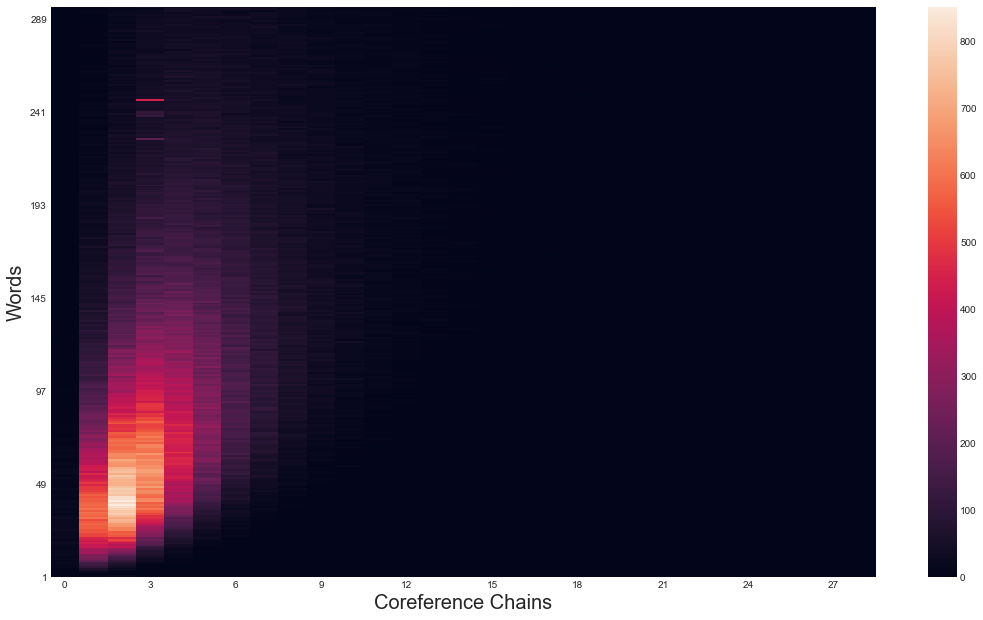

In [181]:
sns.heatmap(df)

plt.xlim(0, 29)
plt.ylim(0, 295)


plt.xlabel('Coreference Chains', fontsize=20)
plt.ylabel('Words', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

TODO:
+ достать пол/дату из текста сообщений
+ узнать какая есть еще инфа про сообщения
+ убрать вхождения не важные для медицинского анализа
